-----------------------------------------

# Prédiction de la demande en électricité sur le marché français

### Mise en situation :

"Enercoop", société coopérative spécialisée dans les énergies renouvelables, s'est développée grâce à la libéralisation du marché de l’électricité en France. La plupart de ces énergies renouvelables est cependant intermittente, il est donc difficile de prévoir les capacités de production d'électricité. De plus, la demande en électricité des utilisateurs varie au cours du temps, et dépend de paramètres comme la météo (température, luminosité, etc.) Ici, le challenge est de mettre en adéquation l'offre et la demande.

## Les enjeux et les objectifs d'une prédiction de la demande en électricité :

L’électricité ne se stocke pas, la production globale sur le réseau électrique français doit, à tout moment, être strictement égale à la consommation. Toute modification de la demande ou de la production d’électricité en un point du réseau se répercute instantanément sur tout le système électrique. Celui-ci doit donc s’adapter en permanence pour satisfaire l’équilibre offre-demande.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.statespace.sarimax import *

from statsmodels.stats.diagnostic import acorr_ljungbox

import scipy.stats as stats

from pandas.plotting import register_matplotlib_converters

import warnings
import itertools
from time import time

In [2]:

%pylab inline
#Paramètres de style
pylab.style.use('fivethirtyeight') 
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 10),
          'lines.linewidth': 1.5,
          'axes.labelsize': 'x-large',
          'axes.titlesize':35,
          'axes.titleweight':'bold',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\Utilisateur\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['time', 'diff']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3]:
#Chargement du dataset 'equilibre-national-mensuel-prod-conso-brute.csv'
data = pd.read_csv('equilibre-national-mensuel-prod-conso-brute.csv', sep=';', parse_dates=[0])
data.head(10)

,Mois,Production totale (GWh),Pompage (GWh),Solde échanges physiques (GWh),Consommation brute (GWh)
0,2014-03-01,48291.0,651.0,4535.0,43104.0
1,2014-06-01,39366.0,632.0,6126.0,32609.0
2,2014-10-01,41312.0,705.0,4306.0,36301.0
3,2014-11-01,47114.0,710.0,5788.0,40617.0
4,2007-01-01,53539.0,759.0,4798.0,47982.0
5,2007-04-01,41106.0,682.0,4610.0,35814.0
6,2007-12-01,53538.0,822.0,1649.0,51067.0
7,2013-02-01,52257.0,470.0,2148.0,49639.0
8,2013-04-01,44117.0,540.0,3285.0,40292.0
9,2013-11-01,48527.0,632.0,2585.0,45310.0


In [4]:
#Création d'un jeu de données mensuelles de consommation totale d'électricité en énergie 
#Restriction sur la modalité 'France' et projection sur les Series pertinentes
conso = data.copy()
conso = conso[['Mois', 'Consommation brute (GWh)']]
conso.rename(columns={'Mois': 'mois', 'Consommation brute (GWh)': 'consommation'}, inplace=True)

In [5]:
#Aperçu des données mensuelles de consommation totale d'électricité en énergie (dataframe "conso")
display(conso.head())
display(conso.shape)

,mois,consommation
0,2014-03-01,43104.0
1,2014-06-01,32609.0
2,2014-10-01,36301.0
3,2014-11-01,40617.0
4,2007-01-01,47982.0


(182, 2)

In [6]:
conso.dtypes

mois            datetime64[ns]
consommation           float64
dtype: object

In [7]:

#Changement d'index pour que la série temporelle soit reconnue
conso = conso.sort_values(by = "mois")
conso = conso.set_index('mois')


In [8]:
#Visualisation des données selon l'indice temporel mois/année
conso

,consommation
mois,
2007-01-01,47982.0
2007-02-01,42469.0
2007-03-01,44401.0
2007-04-01,35814.0
2007-05-01,34993.0
...,...
2021-10-01,36840.0
2021-11-01,44554.0
2021-12-01,49442.0


Text(0.5, 1.0, 'Conso en GWh')

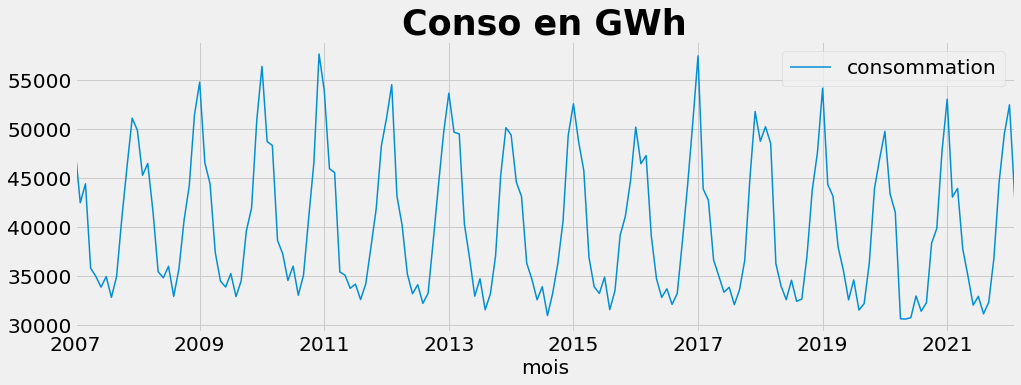

In [9]:
#Visualisation de la consommation totale d'électricité en énergie 
conso.plot(y = "consommation", figsize=(15,5))
plt.savefig("p9_Conso_GWh.png")
plt.title('Conso en GWh')

Dans la série temporelle ci-dessus on peut identifier des cycles assez réguliers au cours du temps et de même amplitude. 

Une correction des données de consommation mensuelles de l'effet température (dues au chauffage électrique) sera faite à l’aide de la régression linéaire.

Il est donc nécessaire d'extraire les données propres au chauffage électrique sur la même période.

In [10]:
#Récapitulatif des consommations annuelles
conso.resample('Y').sum()

,consommation
mois,
2007-12-31,480392.0
2008-12-31,494548.0
2009-12-31,486688.0
2010-12-31,513076.0
2011-12-31,478787.0
2012-12-31,489517.0
2013-12-31,494842.0
2014-12-31,465155.0
2015-12-31,476058.0


### Traitement du jeu de données exporté du site Cegibat, l'expertise efficacité énergétique de GRDF

In [11]:
#Chargement du dataset 'donnee_meteo.csv'
data_dju = pd.read_csv('Donnee_Meteo_2022.csv',sep=';', header=None, skiprows=0)
data_dju.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,NaN,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC,Total
1,2021.0,"396,7","302,8",271,"228,3","138,3",0,0,0,0,0,0,0,"1336,9"
2,2020.0,339,"249,6","268,6","81,4","65,7","20,6","0,9","4,5","34,3","157,5","227,2","336,8","1785,9"
3,2019.0,"404,9","268,3","233,1","168,5","117,9","24,4",0,"1,7","26,7","133,7","282,6","327,3",1989
4,2018.0,"303,4","432,6","314,3","119,7","55,9","8,1",0,"3,3","34,3","122,4","282,5","325,9","2002,2"


In [12]:
#Suppression des deux premières lignes et dernière Series
data_dju.drop([0, 1], axis=0, inplace=True)
data_dju.drop([13], axis=1, inplace=True)

In [13]:
#La première Series est considérée comme index
data_dju[0] = data_dju[0].astype(int)
data_dju.set_index([0], inplace=True)

In [14]:
#Affichage des premières lignes du dataframe 
data_dju.head()

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
2020,339,"249,6","268,6","81,4","65,7","20,6","0,9","4,5","34,3","157,5","227,2","336,8"
2019,"404,9","268,3","233,1","168,5","117,9","24,4",0,"1,7","26,7","133,7","282,6","327,3"
2018,"303,4","432,6","314,3","119,7","55,9","8,1",0,"3,3","34,3","122,4","282,5","325,9"
2017,"467,9","278,4","206,1","182,6",75,"9,4",1,"6,8","62,6","99,4","282,6",369
2016,"364,4","321,6","321,1","212,1","88,1","27,5","5,7","3,2","11,7",176,"285,6","390,8"


Il est nécessaire de transformer ces données de manière à obtenir une matrice temporelle.

In [15]:
#Transformation des données
dju = {'mois':[],'dju_chauffage':[]}

for year in data_dju.index.values:
    for month in data_dju.columns:
        dju['mois'].append(f"{year}-{month}")
        dju['dju_chauffage'].append(data_dju.loc[year,month])
        
dju = pd.DataFrame(dju)
dju['mois'] = pd.to_datetime(dju['mois'])

In [16]:
dju["dju_chauffage"].replace(",", '.')# remplacer la valeur "," par "."
dju["dju_chauffage"] = dju["dju_chauffage"].str.replace(",", ".")
dju["dju_chauffage"] = dju["dju_chauffage"].astype("float")

In [17]:
#Indexation des données selon les mois d'enregistrement
dju.set_index('mois', inplace=True)

In [18]:
#Aperçu des données mensuelles du chauffage électrique (dataframe "dju")
display(dju.head())
display(dju.shape)

,dju_chauffage
mois,
2020-01-01,339.0
2020-02-01,249.6
2020-03-01,268.6
2020-04-01,81.4
2020-05-01,65.7


(144, 1)

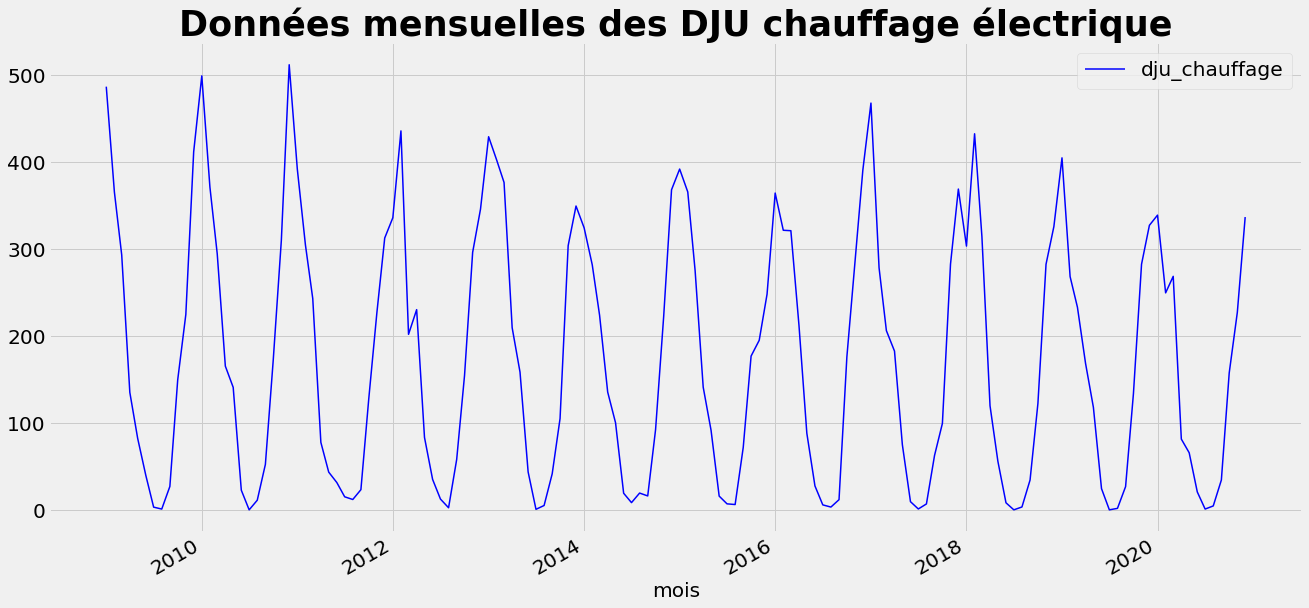

In [19]:
#Visualisation des données mensuelles des Degrés Jour Unifiés (DJU) chauffage électrique

dju.plot(color='b')

plt.title("Données mensuelles des DJU chauffage électrique")
plt.savefig("p9_graphic_dju_chauffage_elec.png")
plt.show()

Cette série temporelle prend naturellement en compte la saisonnalité liée aux conditions climatiques. 

 Nos cycles mensuels évoluent donc en fonction de la température, et d'autres facteurs exogènes non pris en compte dans l'étude comme l’humidité, l'impact de la pollution, etc… Pour finir, les DJU ou Degré Jour Unifié sommés sur une période permettent de calculer les besoins de chauffage et de climatisation d’un bâtiment.

In [20]:
#Création d'un échantillon de travail par jointure des deux précédents dataframe
dataf = pd.merge(conso, dju, how='inner', on='mois')

In [21]:
#Visualisation de notre échantillon suite à la jointure
dataf

,consommation,dju_chauffage
mois,,
2009-01-01,54730.0,486.8
2009-02-01,46530.0,365.7
2009-03-01,44401.0,293.2
2009-04-01,37449.0,135.1
2009-05-01,34516.0,82.2
...,...,...
2020-08-01,31443.0,4.5
2020-09-01,32316.0,34.3
2020-10-01,38364.0,157.5


In [22]:
dataf.tail()

,consommation,dju_chauffage
mois,,
2020-08-01,31443.0,4.5
2020-09-01,32316.0,34.3
2020-10-01,38364.0,157.5
2020-11-01,39872.0,227.2
2020-12-01,47687.0,336.8


In [23]:
#Vérification rapide des éventuelles valeurs manquantes dans l'échantillon
dataf.isna().any()

consommation     False
dju_chauffage    False
dtype: bool

In [24]:
#Statistiques descriptives de l'échantillon
dataf.describe()

,consommation,dju_chauffage
count,144.000000,144.000000
mean,40073.555556,173.763194
std,7187.381079,145.746399
min,30649.000000,0.000000
25%,33897.500000,27.350000
50%,37688.500000,152.100000
75%,45789.250000,298.000000
max,57600.000000,512.000000


L'échantillon de travail étant désormais constitué.  

la prochaine étape consistera à corriger ces données de la consommation en électricité de l'effet température causé par le chauffage.

La régression linéaire sera utilisée.

### Correction des données de consommation mensuelles de l'effet température

L'effet température (dues au chauffage électrique) sera donc corrigé par régression linéaire. Scikit-learn peut-être utilisée ou Statsmodels, à des fins de comparaison les deux méthodes seront traitées.

In [25]:
#Préparation des données pour établir la Régression linéaire 
y=dataf['consommation']
x=dataf.drop(columns=['consommation'])

In [26]:
#Régression linéaire par Scikit-learn
#Instanciation et entrainement du modèle
from sklearn import linear_model
reg = linear_model.LinearRegression(fit_intercept=True)
reg.fit(x, y)

LinearRegression()

In [27]:
#Coefficient de régression linéaire
reg.coef_[0]

48.0156400136793

### Le modèle de Régression linéaire peut également être traité par Statsmodels, c'est ce que nous allons voir:

In [28]:
#Préparation des données pour établir la Régression linéaire
y = dataf['consommation']
x = sm.add_constant(dataf['dju_chauffage'])

In [29]:
#Nouvelle Régression linéaire par Statsmodels
#Instanciation du modèle et entrainement
reg = sm.OLS(y, x).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           consommation   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     2590.
Date:                Mon, 13 Jun 2022   Prob (F-statistic):           4.55e-93
Time:                        14:53:05   Log-Likelihood:                -1269.7
No. Observations:                 144   AIC:                             2543.
Df Residuals:                     142   BIC:                             2549.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.173e+04    213.666    148.504

Le coefficient de détermination de 94% est très satisfaisant, de plus il est identique à celui estimé par le précédent modèle via Scikit-learn.

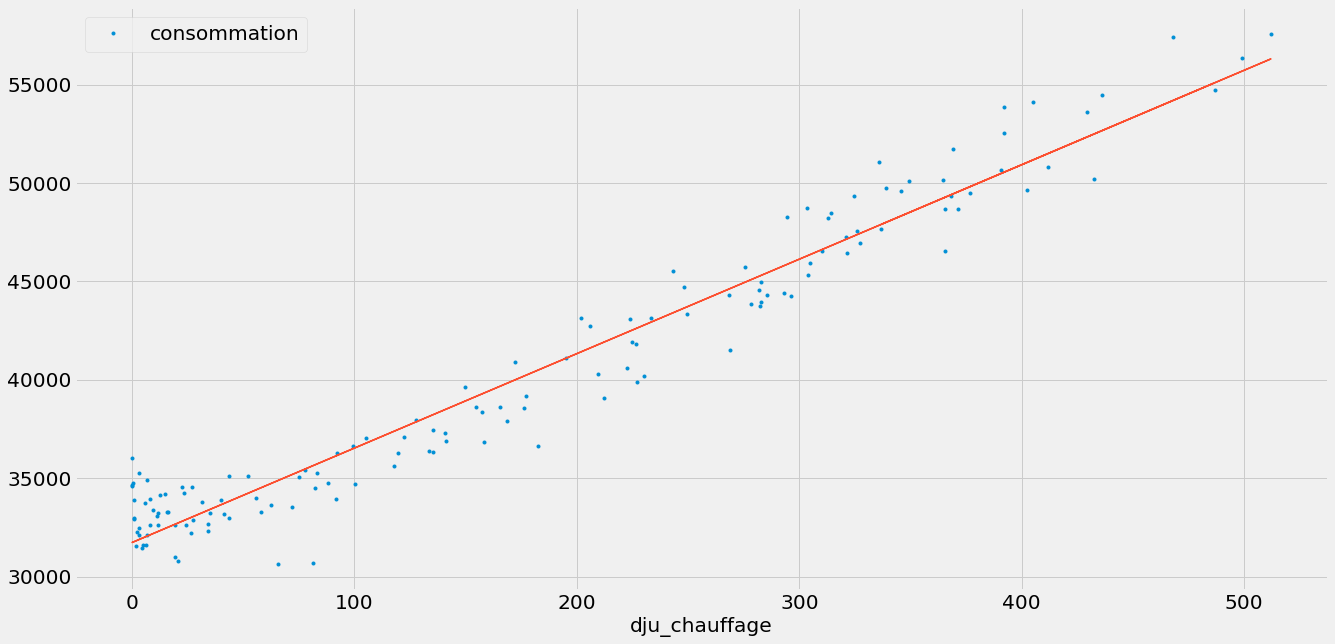

In [30]:
#Représentation de la Régression linéaire obtenue

dataf.plot(x='dju_chauffage', y='consommation', style='.')
plt.plot(dataf['dju_chauffage'], reg.predict(sm.add_constant(dataf['dju_chauffage'])))

plt.savefig("p9_graphic_regression_lineaire_conso_M_dju.png")
plt.show()


In [31]:
#Coefficient de régression linéaire
reg.params['dju_chauffage']

48.015640013679295

Le coefficient de régression linéaire est vérifié par les deux méthodes.


In [32]:
#Calcul de la correction : l'effet DJU est retranché à la consommation totale
dataf['conso_corr'] = dataf['consommation'] - dataf['dju_chauffage']*reg.params['dju_chauffage']

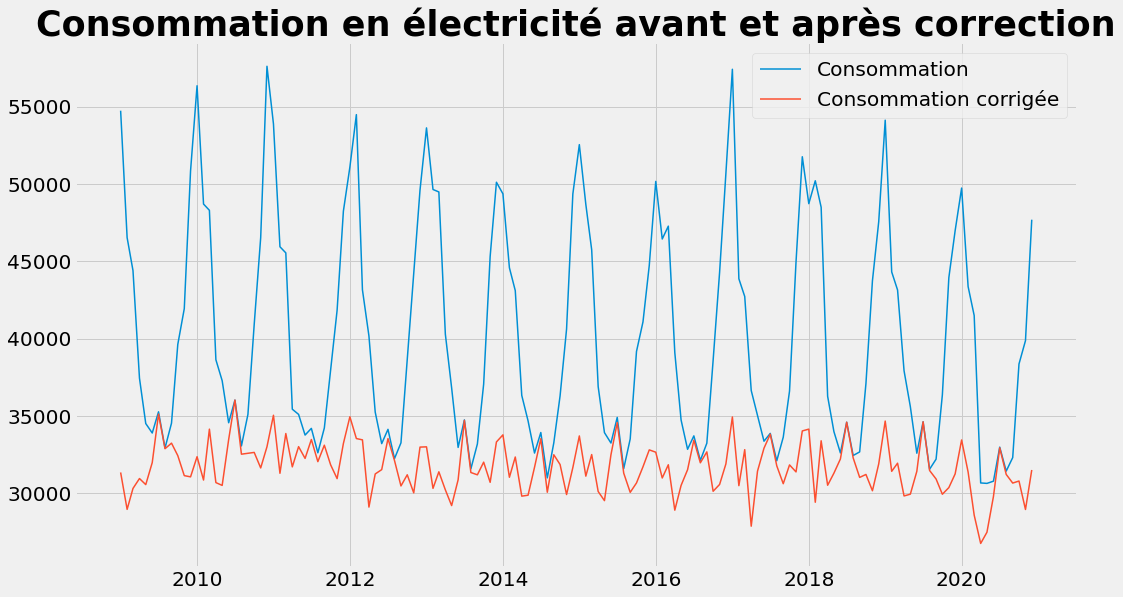

In [33]:
#Visualisation de la consommation en électricité avant et après correction
fig = plt.figure(figsize=(16,9))
plt.plot(dataf['consommation'], label='Consommation')
plt.plot(dataf['conso_corr'], label='Consommation corrigée')
plt.title('Consommation en électricité avant et après correction')

plt.savefig("p9_graphic_conso_corr.png")
plt.legend()
plt.show()

### Test de normalité des résidus :

L’inférence dans la régression linéaire repose sur l’hypothèse de normalité des erreurs. Une première vérification importante consiste à vérifier la compatibilité des résidus (l’erreur observée sur l’échantillon).

In [34]:
# system libraries
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)


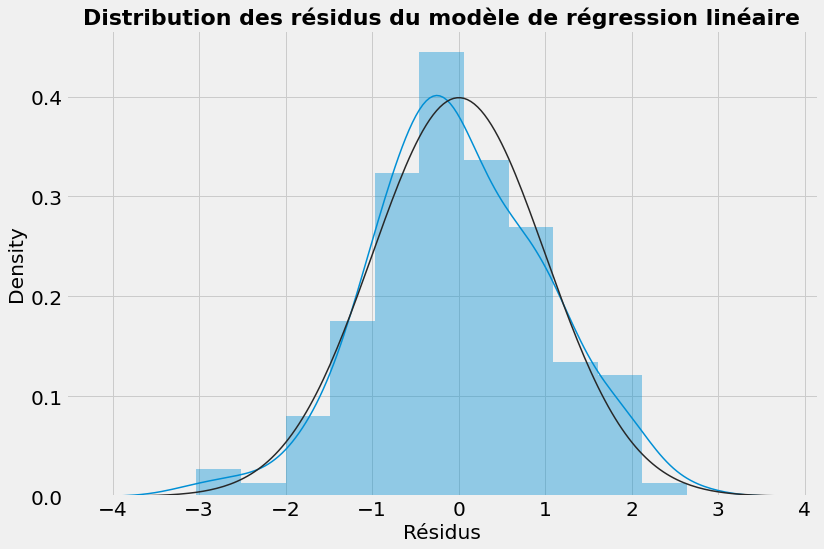

In [35]:
from scipy.stats import norm, shapiro
import seaborn as sns
fig = plt.figure(figsize=(12,8))
ax = sns.distplot(reg.get_influence().resid_studentized_internal, fit=norm)
plt.xlabel('Résidus')
plt.title("Distribution des résidus du modèle de régression linéaire", fontsize=22)
plt.savefig("p9_graphic_Distribution des résidus du modèle de régression linéaire.png")
plt.show()

On remarque donc que la distribution des résidus semble centrée et suivent une loi gaussienne.

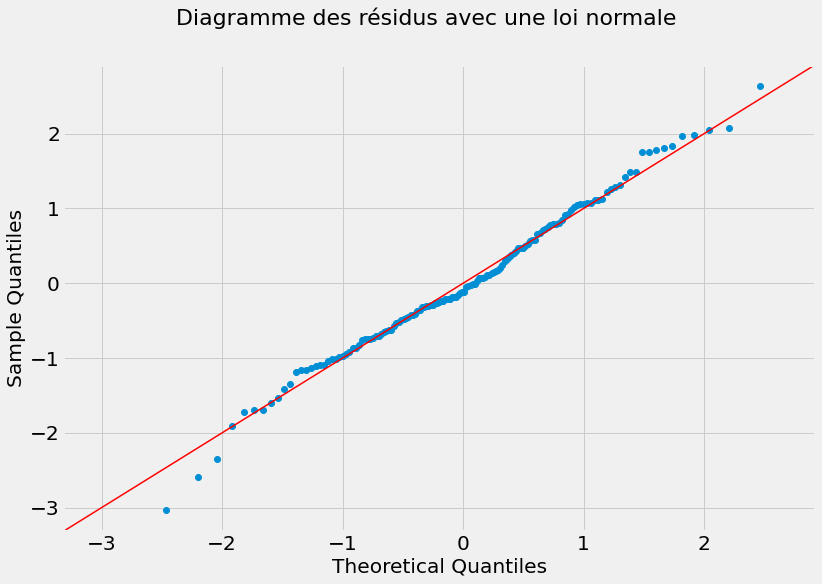

In [36]:
fig = sm.qqplot(reg.get_influence().resid_studentized_internal, fit=True, line="45")
fig.set_size_inches(12, 8)
fig.suptitle("Diagramme des résidus avec une loi normale", fontsize=22)
plt.savefig("p9_graphic_Diagramme des résidus avec une loi normale.png")
plt.show()

On peut identifier une distribution des résidus satisfaisante, alignée avec la distribution théorique d'une loi normale. Un test de Shapiro-Wilk est nécessaire pour valider ou rejeter cette intuition.

In [37]:
#Test de Shapiro-Wilk
shapiro(reg.resid)

ShapiroResult(statistic=0.9926484823226929, pvalue=0.6672773361206055)

La p-value de 0.667  permet  de rejeter l'hypothèse nulle H0 de normalité des résidus, le test n'est pas validé.

# M2

## Désaisonnalisation par moyennes mobiles

## Désaisonnalisation de la consommation obtenue après correction grâce aux moyennes mobiles

Une moyenne mobile est une combinaison linéaire d'instants passés et futurs de notre série temporelle. L'enjeu est de trouver une moyenne mobile qui laisse la tendance invariante, qui absorbe la saisonnalité et qui réduit le résidu :

Notre série temporelle :  Xt=Tt+St+εt

Si on applique une moyenne mobile  M  sur la série, nous obtenons :  MXt=MTt+MSt+Mεt 

Ses propriétés idéales seront donc :

MTt=Tt 

MSt=0 

Mεt  faible

Ici, nous allons utiliser la fonction "seasonal_decompose" du package statsmodels :

#### La méthode seasonal_decompose de statsmodels permet de visualiser la tendance, la saisonnalité et le résidu du signal.

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose

<AxesSubplot:xlabel='mois'>

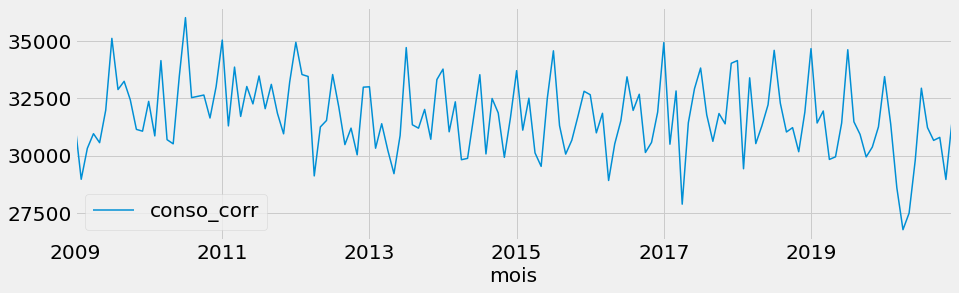

In [39]:
dataf.plot(y="conso_corr", figsize=(14,4))

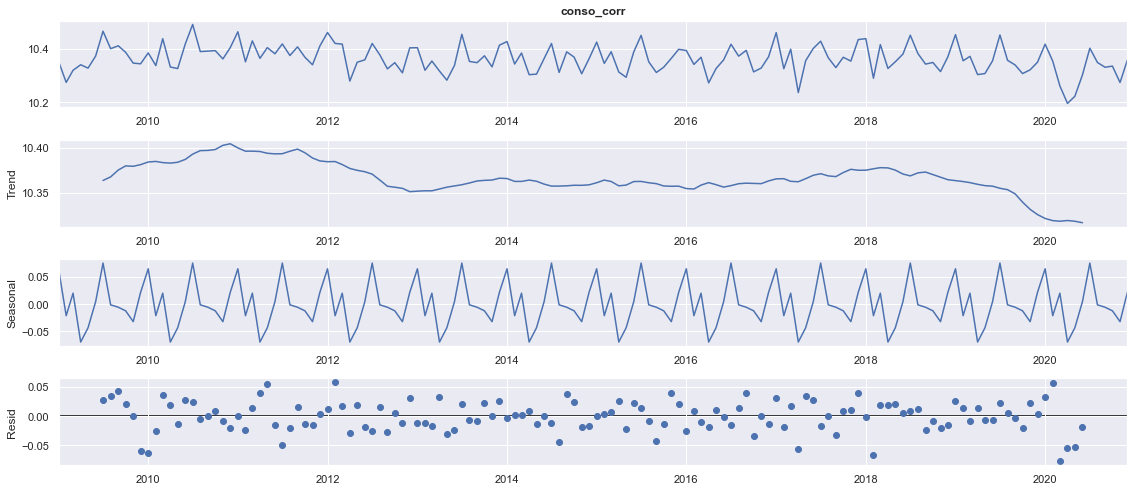

In [40]:
x = dataf["conso_corr"]
y = np.log(x)
sns.set(rc={'figure.figsize':(16, 7)})
decomp_y = seasonal_decompose(y,  model='additive')
decomp_y.plot()
plt.show()

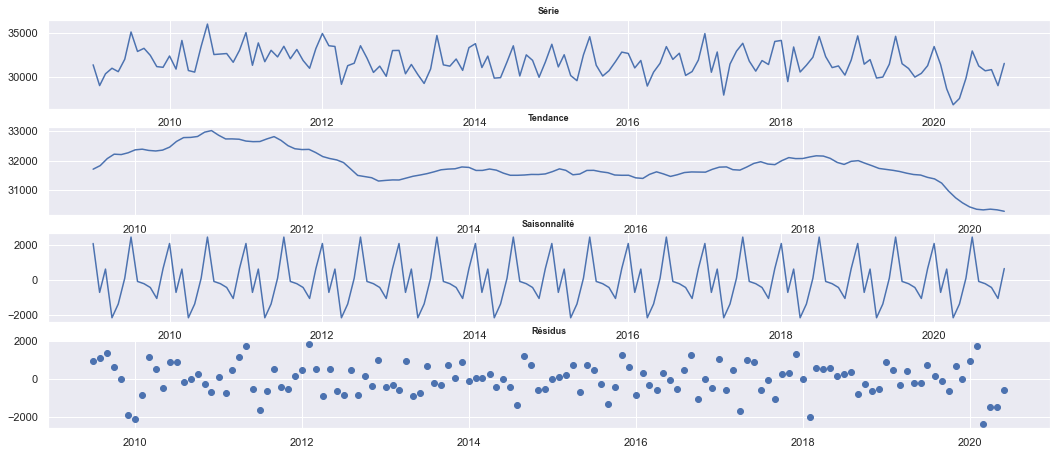

In [41]:
decomposition = seasonal_decompose(dataf['conso_corr'],  model='additive')
x = dataf["conso_corr"]
y = np.log(x)
sns.set(rc={'figure.figsize':(16, 7)})

fig, ax = plt.subplots(4,1)
ax[0].plot(decomposition.observed)
ax[0].set_title('Série', fontsize=9)

ax[1].plot(decomposition.trend)
ax[1].set_title('Tendance', fontsize=9)

ax[2].plot(decomposition.seasonal)
ax[2].set_title('Saisonnalité', fontsize=9)

ax[3].plot(decomposition.resid,'bo')
ax[3].set_title('Résidus', fontsize=9)

plt.savefig('p9_graphic_decomposition_CC.jpg')
plt.show()

In [42]:
#Différence avec la saisonnalité pour obtenir une série temporelle hors impact saisonnier.
dataf['conso_cvs'] = dataf['conso_corr'] - decomposition.seasonal

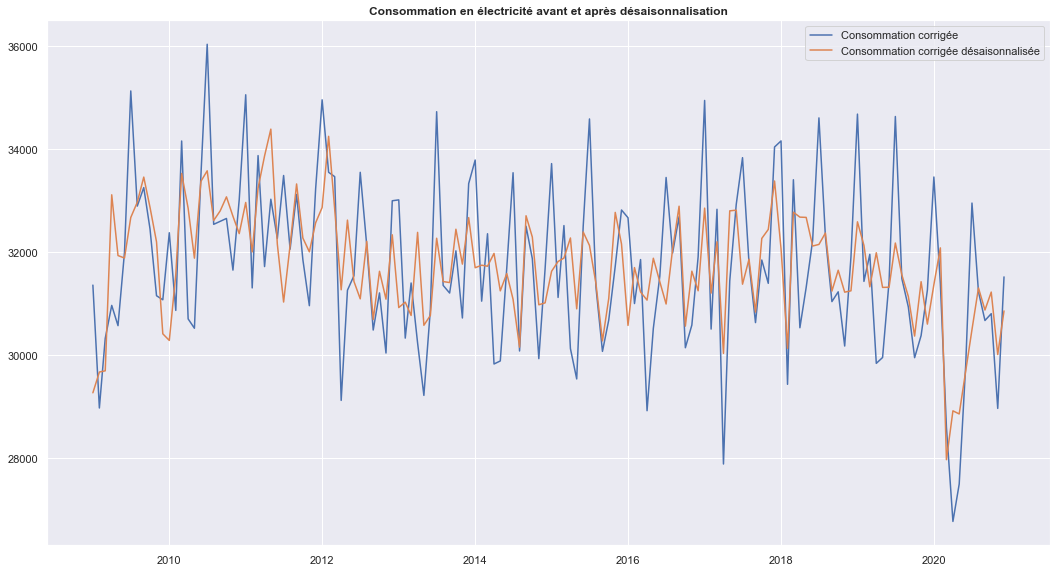

In [43]:
#Visualisation de la consommation en électricité avant et après désaisonnalisation
fig = plt.figure(figsize=(16,9))
plt.plot(dataf['conso_corr'], label='Consommation corrigée')
plt.plot(dataf['conso_cvs'], label='Consommation corrigée désaisonnalisée')
plt.title('Consommation en électricité avant et après désaisonnalisation')

plt.savefig("p9_graphic_conso_A_D.png")
plt.legend()
plt.show()

Le signal ressort corrigé et désaisonnalisé, il est de plus en plus représentatif d'un modèle additif.

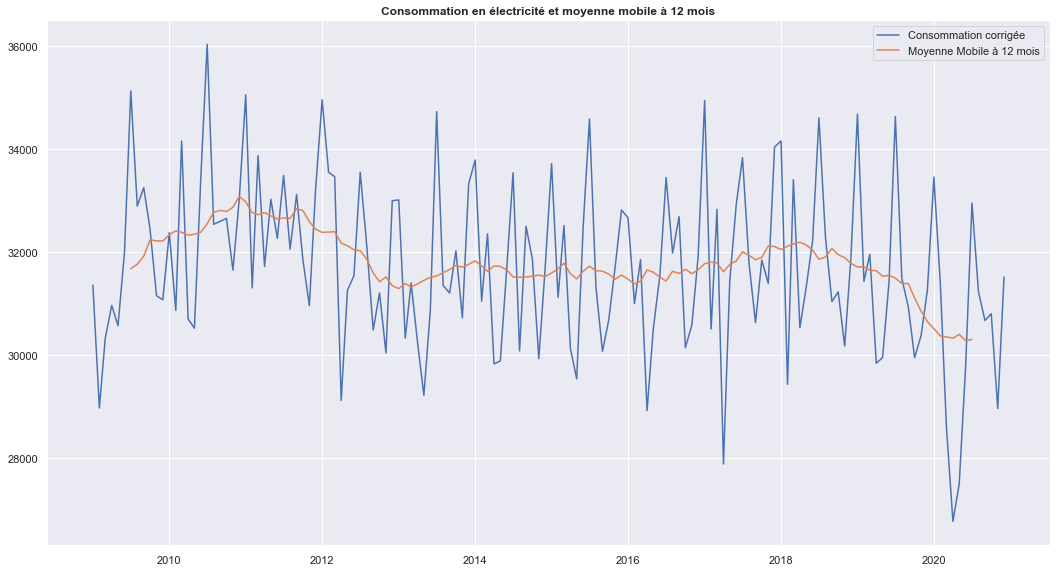

In [44]:
#Visualisation de la consommation en électricité avec moyenne mobile à 12 mois
fig = plt.figure(figsize=(16,9))
plt.plot(dataf['conso_corr'], label='Consommation corrigée')
plt.plot(dataf['conso_corr'].rolling(12, center=True).mean(), label='Moyenne Mobile à 12 mois')


plt.title('Consommation en électricité et moyenne mobile à 12 mois')

plt.savefig("p9_graphic_conso_moyenne_mobile_C.png")
plt.legend()
plt.show()

# M3: Prévision de la consommation (corrigée de l'effet température) sur un an

La phase de prédition se fera en utilisant la méthode de Holt-Winters (lissage exponentiel) puis la méthode SARIMA.

### Prévision à l'aide du lissage exponentiel par la méthode de Holt-Winters

La méthode ExponentialSmoothing de statsmodels est utilisée pour modéliser le lissage exponentiel d'Holt-Winters.

##### Première étape : préparation du modèle, prédiction et index des dates

In [45]:
duree_pred = 12
tronc = duree_pred
data = dataf['conso_corr']
dataf_tronc = data[:-tronc]
data_prevoir = data[-tronc:]

In [46]:
def rmse(serie1, serie2):
    return np.sqrt(((serie1-serie2)**2).mean())

def mape(serie1, serie2):
    return (np.abs(1-serie1/serie2)).mean()*100

La méthode de Holt-Winters est la plus raisonnable des méthodes de lissage exponentiel. La prévision sur un an de la consommation, corrigée de l'effet température, tient compte de la saisonnalité. Ci-dessous une visualisation par restriction sur la période 2020/2021.

In [47]:
# création du modèle
HW_mod_2 = ExponentialSmoothing(np.asarray(data), seasonal_periods=12, trend='additive', seasonal='additive').fit()
# prédiction
HW_pred_2 = HW_mod_2.forecast(duree_pred)
# on ajoute en index les dates correspondantes aux prédictions
HW_pred_2 = pd.Series(HW_pred_2, index = pd.date_range(data.index.max(), periods=duree_pred, freq='M'))

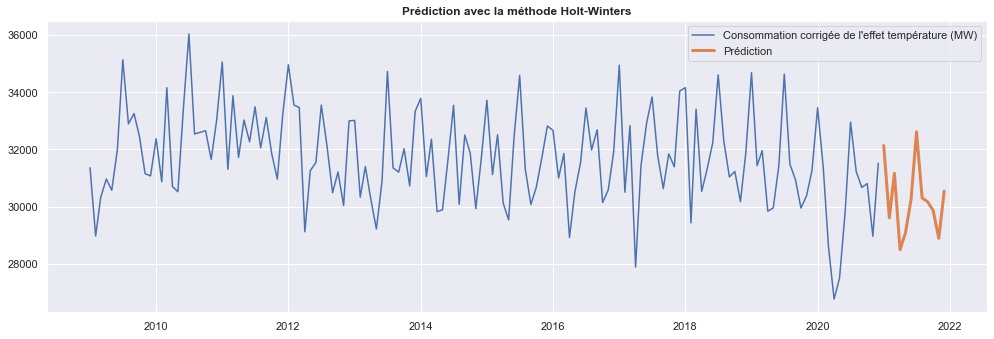

In [48]:
#Tracé de la figure
plt.figure(figsize=(15,5))
plt.plot(data, label="Consommation corrigée de l'effet température (MW)")
plt.plot(HW_pred_2, label='Prédiction', linewidth=3)
plt.title('Prédiction avec la méthode Holt-Winters')
_ =plt.legend()
plt.savefig("p9_graphic_Prédiction avec la méthode Holt-Winters.png")

La forte saisonnalité de la série est potentiellement prévisible par Holt Winters. 

###  vérification a posteriori sur les données de l'année passée

In [49]:
#Création du modèle sur le dataframe tronqué de 12 mois
HW_mod_1 = ExponentialSmoothing(np.asarray(dataf_tronc), seasonal_periods=12, trend='additive', seasonal='additive').fit()

In [50]:
#Prédiction & indexage
HW_pred_1 = HW_mod_1.forecast(duree_pred)
HW_pred_1 = pd.Series(HW_pred_1, index = data_prevoir.index)

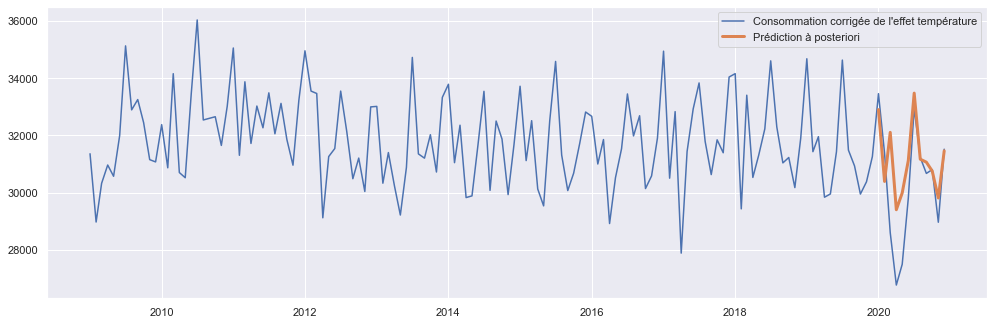

In [51]:
#Figure
plt.figure(figsize=(15,5))
plt.plot(data, label="Consommation corrigée de l'effet température")
plt.plot(HW_pred_1, label='Prédiction à posteriori', linewidth=3)
plt.legend()
plt.savefig("p9_graphic_Prédiction à posteriori_Holt-Winters.png")

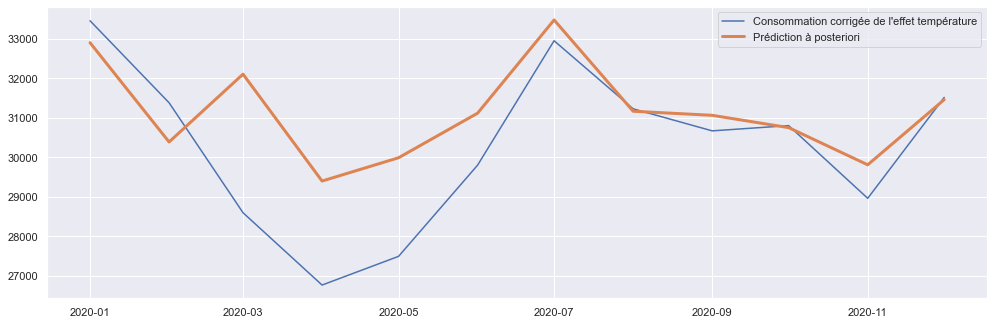

In [52]:
#Zoom sur les 12 derniers mois
plt.figure(figsize=(15,5))
plt.plot(data[-12:], label="Consommation corrigée de l'effet température")
plt.plot(HW_pred_1.iloc[-12:], label='Prédiction à posteriori', linewidth=3)
plt.legend()
plt.savefig("p9_graphic_Prédiction_Consommation corrigée de l'effet température.png")

#### Performance du modèle

In [53]:
print('RMSE :', (round(rmse(data_prevoir, HW_pred_1), 4)), 
      '\n', 'MAPE:', (round(mape(data_prevoir, HW_pred_1), 4)))

RMSE : 1570.9307 
 MAPE: 3.6322


## Méthode SARIMA

In [54]:
#Rappel des paramètres
duree_predite = 12
troncature = duree_predite
y = dataf['conso_corr']
y_tronc = y[:-troncature]
y_a_prevoir = y[-troncature:]

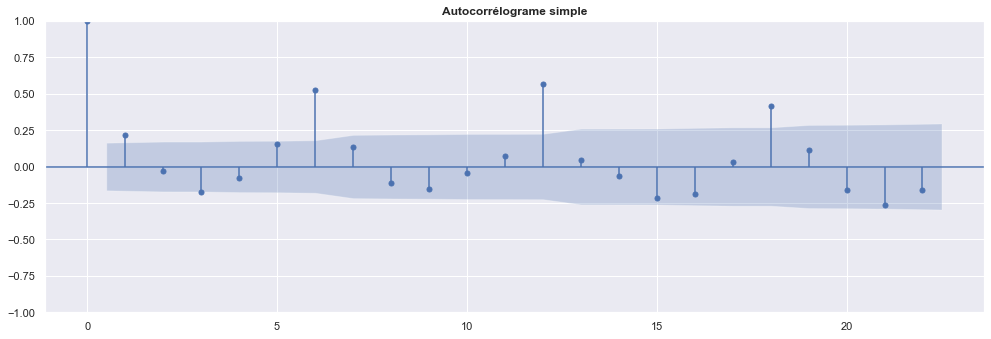

In [55]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(y, ax=ax)
plt.title('Autocorrélograme simple')
plt.show()

La sortie ACF présente une décroissance lente vers 0, ce qui traduit un problème de non-stationnarité. 

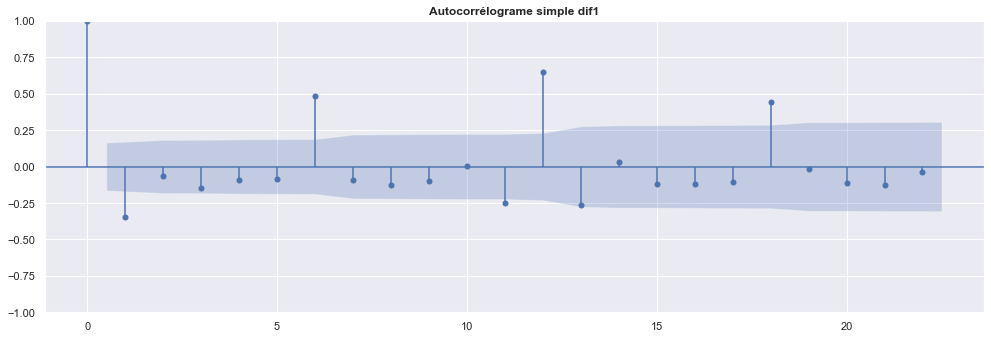

In [56]:
y_dif1 = (y - y.shift(1)).dropna()
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(y_dif1, ax=ax)
plt.title('Autocorrélograme simple dif1')
plt.show()

La sortie ACF de la série ainsi différenciée présente encore une décroissance lente vers 0 pour les multiples de 12. On effectue cette fois la différenciation d'ordre 12.

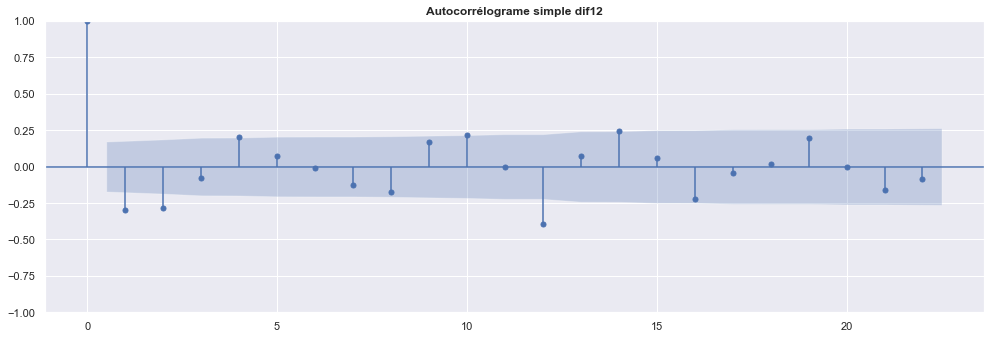

In [57]:
y_dif2 = (y_dif1 - y_dif1.shift(12)).dropna()
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(y_dif2, ax=ax)
plt.title('Autocorrélograme simple dif12')
plt.show()

Cette fois-ci les résultats sont satisfaisants, nous pouvons nous appuyer sur les autocorrélogrammes simple et partiels estimés.

### Génération d'une configuration optimale SARIMA :

L’identification des combinaisons sera faite par l’approche d’optimisation des polynômes AR et MA. Nous cherchons à minimiser le critère d’information d’Akaike AIC pour déterminer les ordres optimaux. 

La blancheur et normalité du résidu est également un critère à prendre en compte.

In [58]:
import itertools
from time import time

# toute les combinaisons de p, d et q
pdq_list = list(itertools.product(range(3),
                             range(2), 
                             range(3)
           ))
# toute les combinaisons de P, D et Q
PDQ_list = [ (*val, 12) for val in list(itertools.product(
                            range(3), 
                            range(2), 
                            range(3))
            )]

# nombre de configurations
n = len(pdq_list) * len(PDQ_list)


grid_search_result = pd.DataFrame({'modele':[], 'AIC':[], 'BIC':[], 'rmse':[], 'mape':[], 'pvalue':[]})
counter = 1
s_time = time()

for pdq in pdq_list:
    for PDQ in PDQ_list:
        try:
            # calcul du modèle sur y_tronc
            mod = SARIMAX(np.asarray(y_tronc),
                          order = pdq,
                          seasonal_order = PDQ,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            result = mod.fit()
            
             
            # on fait une prédiction sur 1 ans
            prediction = result.get_forecast(duree_predite).predicted_mean
           
            # on stocke l'AIC, le BIC le RMCE et le MAPE de ce modèle
            grid_search_result = grid_search_result.append({'modele':f"{pdq}x{PDQ}", 
                            'AIC':result.aic, 
                            'BIC':result.bic,
                            'rmse': rmse(y_a_prevoir, prediction),
                            'mape': mape(y_a_prevoir, prediction),
                            'pvalue': result.pvalues.min()},
                            ignore_index=True)
        except:
            continue
            clear_output(' ')
            print(f"{counter}/{n} - {time() - s_time:.0f}s")
            counter += 1

In [59]:
grid_search_result_filter = grid_search_result[grid_search_result['pvalue'] < 0.05]
#Utilisation de la fonction .rank() pour déterminer la position de chaque modèle selon la minimisation AIC / BIC
grid_search_result_filter['rank_aic'] = grid_search_result_filter['AIC'].rank(ascending=True)
grid_search_result_filter['rank_bic'] = grid_search_result_filter['BIC'].rank(ascending=True)
grid_search_result_filter['rank_RMSE'] = grid_search_result_filter['rmse'].rank(ascending=True)
grid_search_result_filter['rank_MAPE'] = grid_search_result_filter['mape'].rank(ascending=True)

In [60]:
grid_search_result_filter['total'] = grid_search_result_filter['rank_aic']+grid_search_result_filter['rank_bic']+grid_search_result_filter['rank_RMSE']+grid_search_result_filter['rank_MAPE']
grid_search_result_filter['rank_total'] = grid_search_result_filter['total'].rank(ascending=True)

In [61]:
grid_search_result_filter.sort_values('rank_total', ascending=True)

,modele,AIC,BIC,rmse,mape,pvalue,rank_aic,rank_bic,rank_RMSE,rank_MAPE,total,rank_total
317,"(2, 1, 2)x(1, 1, 2, 12)",1522.344440,1542.518749,1456.585394,3.510908,2.101812e-07,6.0,8.0,37.0,8.0,59.0,1.0
299,"(2, 1, 1)x(1, 1, 2, 12)",1541.722253,1559.450449,1461.017151,3.486021,1.107781e-11,21.0,25.0,41.0,6.0,93.0,2.0
215,"(1, 1, 2)x(2, 1, 2, 12)",1541.019263,1561.193571,1441.631653,3.602607,8.285025e-07,17.0,29.0,32.0,19.0,97.0,3.0
101,"(0, 1, 2)x(1, 1, 2, 12)",1519.658281,1534.789012,1518.194124,3.636845,2.077317e-18,2.0,2.0,71.0,24.0,99.0,4.0
209,"(1, 1, 2)x(1, 1, 2, 12)",1521.656333,1539.308853,1517.139213,3.634854,9.490676e-10,5.0,5.0,69.0,23.0,102.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19,"(0, 0, 1)x(0, 0, 1, 12)",2683.037337,2691.349391,15295.672744,103.324029,0.000000e+00,317.0,317.0,319.0,318.0,1271.0,318.0
1,"(0, 0, 0)x(0, 0, 1, 12)",2728.163031,2733.721278,14927.730808,96.246263,0.000000e+00,319.0,319.0,317.0,317.0,1272.0,319.0
36,"(0, 0, 2)x(0, 0, 0, 12)",2933.663625,2942.243062,28311.241143,inf,0.000000e+00,320.0,320.0,320.0,321.5,1281.5,320.0
18,"(0, 0, 1)x(0, 0, 0, 12)",2977.970098,2983.705167,29474.474914,inf,0.000000e+00,321.0,321.0,321.0,321.5,1284.5,321.0


 Selon la minimisation du critère AIC et BIC , le modèle (2, 1, 2)x(1,1,2,12) ressort comme étant le plus optimal. Ce choix a été fait après plusieurs tests sur plusieurs modèles, il ressort comme étant le plus performant en tenant compte également de la significativité des paramètres

In [63]:
#On entre les paramètres obtenus dans le modèle
SARIMA_mod_tronc = SARIMAX(np.asarray(dataf_tronc), 
                           order=(2, 1, 2), 
                       seasonal_order=(1, 1, 2, 12), 
                       enforce_invertibility=False, 
                       enforce_stationarity=False)
sarima_res_tronc = SARIMA_mod_tronc.fit()
print(sarima_res_tronc.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(2, 1, 2)x(1, 1, 2, 12)   Log Likelihood                -753.172
Date:                            Mon, 13 Jun 2022   AIC                           1522.344
Time:                                    15:06:45   BIC                           1542.519
Sample:                                         0   HQIC                          1530.487
                                            - 132                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0574      0.419     -0.137      0.891      -0.878       0.763
ar.L2         -0.1424      0.151   

### Normalité des résidus :

Dans le cadre de prévisions, il convient de vérifier la normalité des résidus pour tester l'adéquation de nos modèles. La normalité peut-être détectée de façon graphique, mais des tests statistiques amènent un point de vue objectif non négligeable.

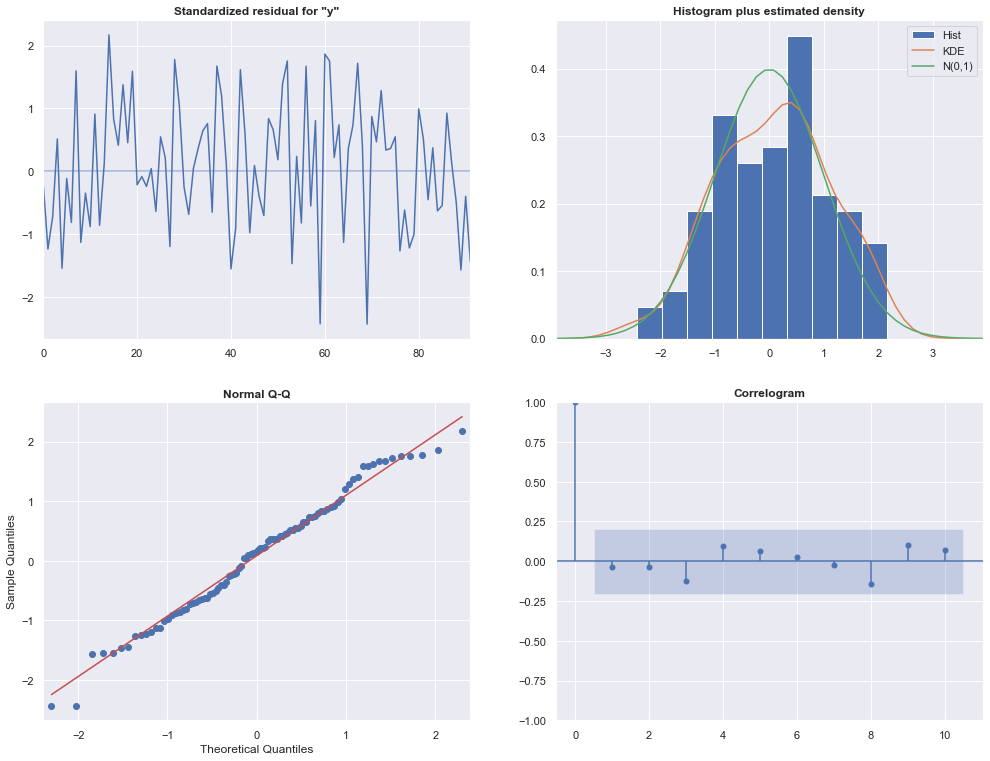

In [64]:
sarima_res_tronc.plot_diagnostics(figsize=(15, 12))
plt.show()

La représentation "Standardized residual" et "Correlogram" confirment qu'il n'y a pas de corrélation des résidus. Les résidus sont normalement distribués KDE vs distribution normale - N (0,1). La distribution ordonnée des résidus représentée par le du Q-Q plot est globalement satisfaisant, il y a quand même des petites divergences vers les queues de distribution. Il est intéressant de coupler l'approche visuelle par des tests statistiques.

In [65]:
#Test de Shapiro-Wilk
from scipy.stats import shapiro
shapiro(sarima_res_tronc.resid)

ShapiroResult(statistic=0.4190846085548401, pvalue=1.2056597675454364e-20)

Ici, l'hypothèse de normalité est remise en cause par Shapiro (p-value < 0.05).

Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante permettent de dire que les résultats obtenus par le modèle ne sont pas absurdes, même si le résidu n'est pas considéré comme étant gaussien.

In [66]:
sarima_pred_tronc = sarima_res_tronc.get_forecast(duree_pred)
sarima_pred_tronc_fig = pd.DataFrame(sarima_pred_tronc.predicted_mean, index = data_prevoir.index)

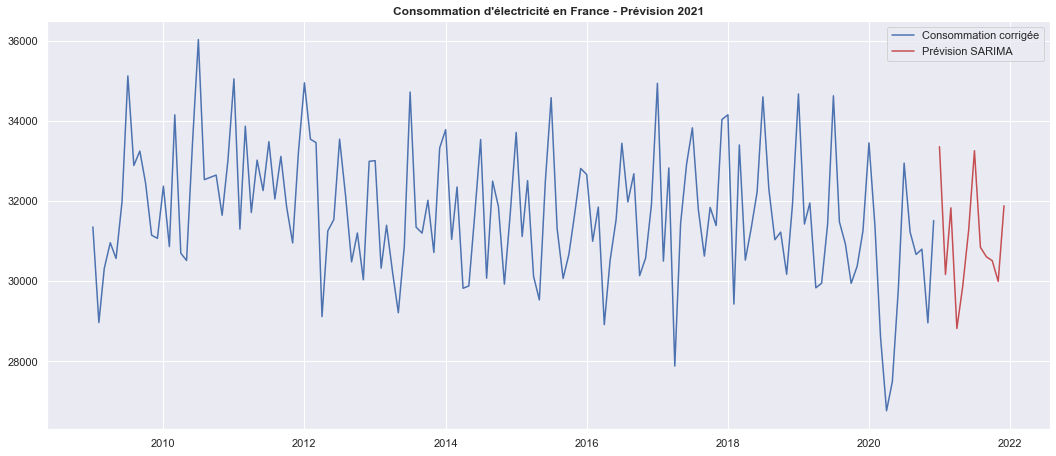

In [67]:
#Visualisation de la prévision à 12 mois par la méthode SARIMA
pred_model = sarima_res_tronc.get_forecast(12)
pred = pred_model.predicted_mean

plt.plot(dataf['conso_corr'], label='Consommation corrigée')
plt.plot(pd.date_range(dataf.index[len(dataf)-1], periods=12, freq='M'), pred, color='r', label='Prévision SARIMA')

plt.title("Consommation d'électricité en France - Prévision 2021")
plt.legend()

plt.savefig('p9_graphic_sarima_prevision2021.jpg')
plt.show() 

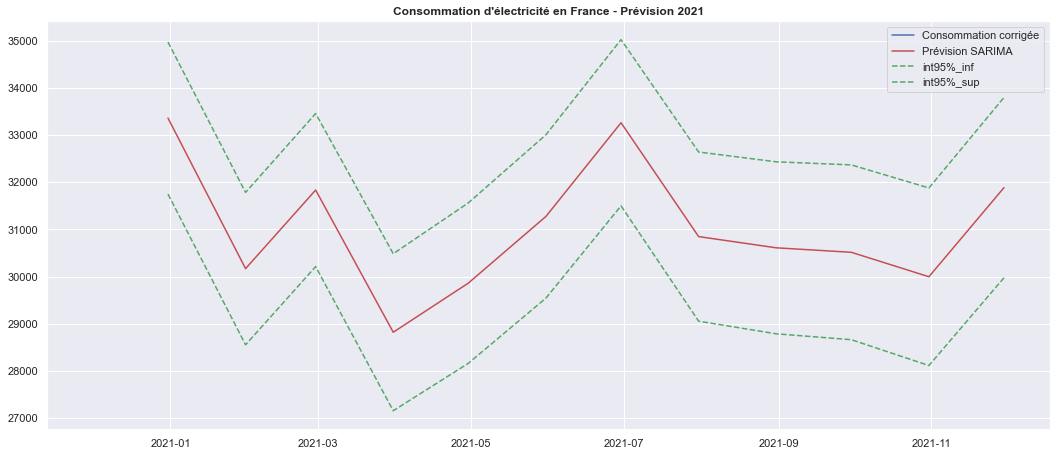

In [68]:
#Visualisation des intervalles de confiance sur la prévision à 12 mois
pred_model = sarima_res_tronc.get_forecast(12)
pred = pred_model.predicted_mean

pred_l = [(elt[0]) for elt in pred_model.conf_int(alpha=0.05)]
pred_u = [(elt[1]) for elt in pred_model.conf_int(alpha=0.05)]

plt.plot(dataf['conso_corr'].iloc[-1:], label='Consommation corrigée')
plt.plot(pd.date_range(dataf.index[len(dataf)-1], periods=12, freq='M'), pred, color='r', label='Prévision SARIMA')
plt.plot(pd.date_range(dataf.index[len(dataf)-1], periods=12, freq='M'), 
         pred_l, color='g', linestyle='--', label='int95%_inf')
plt.plot(pd.date_range(dataf.index[len(dataf)-1], periods=12, freq='M'), 
         pred_u, color='g', linestyle='--', label='int95%_sup')

plt.title("Consommation d'électricité en France - Prévision 2021")
plt.legend()

plt.savefig('p9_graphic_sarima_prevision2021_int95.jpg')
plt.show() 

### Analyse a posteriori

In [69]:
#Troncature des données sur les années 2020 et 2021
dataf_tronc = dataf[:'2020'] 
x_prevision = dataf['2021':]  

In [71]:
model_tronc = SARIMAX(np.asarray(dataf_tronc['conso_corr']), order=(1, 1, 2), seasonal_order=(1,1,2,12))
results_tronc = model_tronc.fit()
print(results_tronc.summary())


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood               -1133.077
Date:                            Mon, 13 Jun 2022   AIC                           2280.154
Time:                                    15:14:35   BIC                           2300.280
Sample:                                         0   HQIC                          2288.332
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9822      0.043     22.734      0.000       0.898       1.067
ma.L1         -1.2571      0.051   

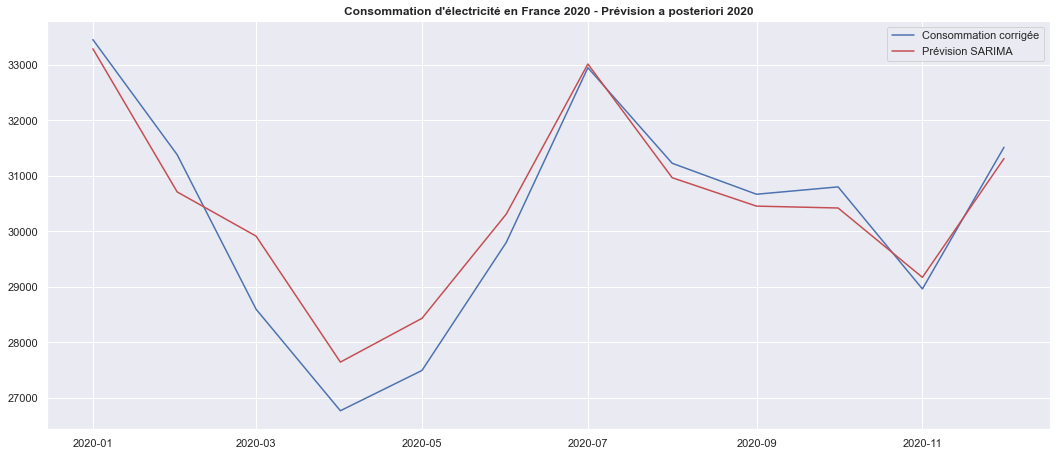

In [72]:
#Visualisation par restriction sur l'année 2020
pred_model_tronc = results_tronc.get_forecast(12)
pred_tronc = pred_model_tronc.predicted_mean

plt.plot(dataf["conso_corr"].iloc[-12:], label='Consommation corrigée')
plt.plot(HW_pred_1.iloc[-12:].index, pred_tronc, color='r', label='Prévision SARIMA')


plt.title("Consommation d'électricité en France 2020 - Prévision a posteriori 2020")
        
plt.legend()
plt.savefig("p9_graphic_prevision_visu2020_sarima_aposteriori.png")
plt.show()

In [73]:
print('RMSE :', (round(rmse(data_prevoir, sarima_pred_tronc_fig.squeeze()), 4)), 
      '\n', 'MAPE:', (round(mape(data_prevoir, sarima_pred_tronc_fig.squeeze()), 4)))

RMSE : 1456.5854 
 MAPE: 3.5109


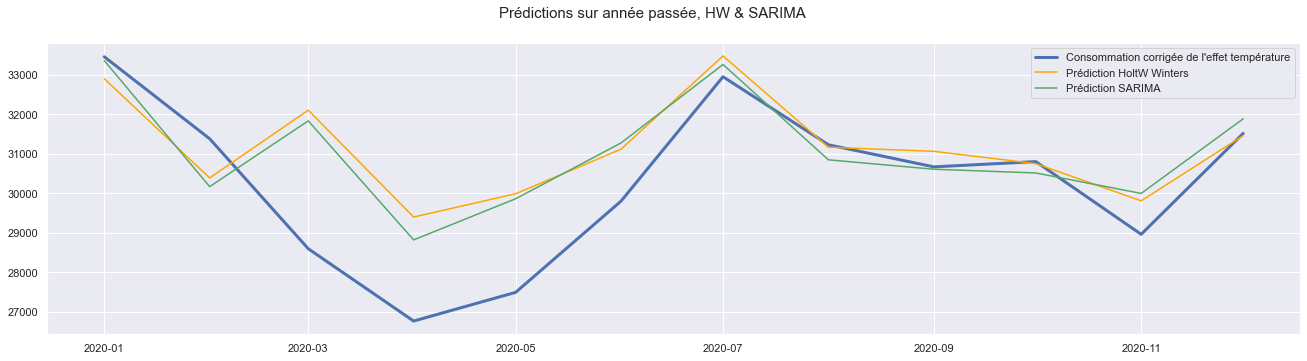

In [74]:
#Zoom sur les prédictions passées HW & SARIMA
fig = plt.figure(figsize=(20,5))
fig.suptitle('Prédictions sur année passée, HW & SARIMA', fontsize=15)
plt.plot(data[-12:], label="Consommation corrigée de l'effet température",linewidth=3)
plt.plot(HW_pred_1.iloc[-12:], color = 'orange', label='Prédiction HoltW Winters')
plt.plot(sarima_pred_tronc_fig.iloc[-12:], 'g', label='Prédiction SARIMA')
plt.legend()

### conclusion

Dans cette étude, nous avons utilisé les données mensuelles de consommation d’électricité en France, ainsi que l'effet de température lié au chauffage pour tester des modèles de prévison de cette consommation à 12 mois. L’exploration de ces données nous a révélé des caracteristiques tels que la non stationnarité de la série de consommation d’électricité et sa très forte inertie (autocorrélation forte et longue). Deux processus de différenciation ont été nécessaire pour rendre la série stationnaire.

On remarque que les 2 modèles de traitement des séries temporelles utilisées nous apportent des résultats relativement similaire, ce qui traduit à nouveau la bonne performance de ces prédictions.

Les prévisions par la méthode de lissage exponentiel Holt-Winters et SARIMA sont globablement satisfaisantes.

